In [2]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)


Using Pytorch version :  1.10.0  Device :  cuda


In [3]:
#CIFAR10 데이터를 이용한 MLP 설계
#1. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 이미지
EPOCHS = 10 # 전체 데이터 셋을 10번 반복

In [4]:
# 2. 데이터 다운로드. Train Set, Test set 분리

train_dataset = datasets.CIFAR10(root="../data/CIFAR_10",
                               train=True,
                               download=True,
                               transform = transforms.ToTensor())
#train_set download. ToTensor()로 255스칼라값을 데이터를 0~1로 정규화.
#과적화 방지를 위해.
test_dataset = datasets.CIFAR10(root="../data/CIFAR_10",
                               train=False,
                               download=True,
                               transform = transforms.ToTensor())
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # 순서가 암기되는것을 막기위해.
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

5.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

15.2%IOPub me

X_train :  torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor


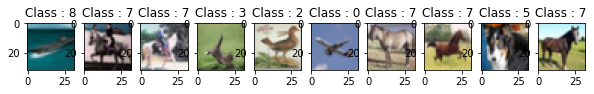

In [6]:
# 3. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

#배치 데이터한개
#X: 이미지. 32배치 사이즈. 3 rgb. 32x32 이미지.
#Y: 32개의 라벨

#print(np.transpose(X_train[i],(1,2,0)).shape)

# 이미지 데이터확인
#np.transpose로 (채널,세로,가로) -> (세로,가로,채널) 이렇게 해야지 그릴 수 있다.
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))#하나당 10,1

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.transpose(X_train[i],(1,2,0)))# 배치에서 10개만 추출
    plt.title('Class : '+str(Y_train[i].item()))


In [20]:
#6. 모델 MLP 설계
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        self.fc1 = nn.Linear(32*32*3,512) # fully connected layer.
        #노드수 : 32*32*3
        #아웃풋 노드수 512
        self.fc2 = nn.Linear(512,256)#첫번째 히든레이어
        self.fc3 = nn.Linear(256,10)#두번째 히든레이어.
        #아웃풋 10개. 10개 클래스
    
    def forward(self,x):
        x = x.view(-1,32*32*3) #***이미지를 flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [28]:
# 6-2. 모델. drop out 추가.
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        self.fc1 = nn.Linear(32*32*3,512) # fully connected layer.
        #노드수 : 32*32*3
        #아웃풋 노드수 512
        self.fc2 = nn.Linear(512,256)#첫번째 히든레이어
        self.fc3 = nn.Linear(256,10)#두번째 히든레이어.
        #아웃풋 10개. 10개 클래스
        self.dropout_prob=0.5 # 반을 dropout
    
    def forward(self,x):
        x = x.view(-1,32*32*3) #***이미지를 flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x,training=self.training,p=self.dropout_prob)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x,training=self.training,p=self.dropout_prob)
        
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [52]:
#7. Optimizer, Objective Function
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
#원핫 인코딩값의 loss는 crossEntropyLoss로 비교
print(model)


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [53]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.        

In [54]:
#9. 학습 진행하며, test 데이터로 모델 성능확인
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            #print(output.max(1,keepdim=True))
            #print(prediction)
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss,test_accuracy
            

In [27]:
#10. 학습 및 평가.
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval=200)
    test_loss,test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))


[EPOCH:1], 	Test Loss:0.0469 	Test Accuracy: 46.73 %


[EPOCH:2], 	Test Loss:0.0472 	Test Accuracy: 46.14 %


[EPOCH:3], 	Test Loss:0.0466 	Test Accuracy: 47.40 %


[EPOCH:4], 	Test Loss:0.0469 	Test Accuracy: 47.76 %


[EPOCH:5], 	Test Loss:0.0458 	Test Accuracy: 48.47 %


[EPOCH:6], 	Test Loss:0.0475 	Test Accuracy: 46.19 %


[EPOCH:7], 	Test Loss:0.0445 	Test Accuracy: 50.00 %


[EPOCH:8], 	Test Loss:0.0451 	Test Accuracy: 49.34 %


[EPOCH:9], 	Test Loss:0.0452 	Test Accuracy: 49.36 %


[EPOCH:10], 	Test Loss:0.0457 	Test Accuracy: 48.06 %



In [32]:
#10. 학습 및 평가.
# dropout
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval=200)
    test_loss,test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))


[EPOCH:1], 	Test Loss:0.0612 	Test Accuracy: 28.97 %


[EPOCH:2], 	Test Loss:0.0605 	Test Accuracy: 29.86 %


[EPOCH:3], 	Test Loss:0.0606 	Test Accuracy: 30.17 %


[EPOCH:4], 	Test Loss:0.0599 	Test Accuracy: 31.01 %


[EPOCH:5], 	Test Loss:0.0598 	Test Accuracy: 31.45 %


[EPOCH:6], 	Test Loss:0.0587 	Test Accuracy: 35.34 %


[EPOCH:7], 	Test Loss:0.0601 	Test Accuracy: 31.71 %


[EPOCH:8], 	Test Loss:0.0588 	Test Accuracy: 31.75 %


[EPOCH:9], 	Test Loss:0.0603 	Test Accuracy: 35.12 %


[EPOCH:10], 	Test Loss:0.0593 	Test Accuracy: 35.62 %



In [51]:
#6 -3. CNN 모델
# 6-2. 모델. drop out 추가.
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        #컨볼루션 커널 정의 및 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels = 3,# RGB이자,이미지 두께가 몇개인지
            out_channels = 8,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        # 파라미터수: (3x3x 3(rgb) )x8 :
        #결과로 3개의 평면이 -> 8개의 피처맵으로.
        self.conv2 = nn.Conv2d(
            in_channels = 8,# featureMap 8개
            out_channels = 16,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        #8개의 피처맵 -> 16개 피처맵
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        #이미지의 크기가 4분의 1줄어든다.
        
        #Fully-connected layer
        self.fc1 = nn.Linear(8*8*16,64)# pooling두번해서 8*8 이미지
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,10)
        
    
    def forward(self,x):
        x = self.conv1(x)#flatten 없어도 된다.
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1,8*8*16)#피처맵을 flatten
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)#10개 클래스
        return x

In [55]:
#10. 학습 및 평가.
# CNN
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval=200)
    test_loss,test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))

C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



[EPOCH:1], 	Test Loss:0.0460 	Test Accuracy: 46.07 %


[EPOCH:2], 	Test Loss:0.0424 	Test Accuracy: 50.85 %


[EPOCH:3], 	Test Loss:0.0397 	Test Accuracy: 54.17 %


[EPOCH:4], 	Test Loss:0.0379 	Test Accuracy: 55.97 %


[EPOCH:5], 	Test Loss:0.0357 	Test Accuracy: 60.09 %


[EPOCH:6], 	Test Loss:0.0360 	Test Accuracy: 58.95 %


[EPOCH:7], 	Test Loss:0.0346 	Test Accuracy: 60.94 %


[EPOCH:8], 	Test Loss:0.0343 	Test Accuracy: 61.57 %


[EPOCH:9], 	Test Loss:0.0347 	Test Accuracy: 61.30 %


[EPOCH:10], 	Test Loss:0.0331 	Test Accuracy: 62.47 %

